<a href="https://colab.research.google.com/github/asiyashazmi/IBM-Coursera-Capstone/blob/master/Restaurants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***IBM CAPSTONE PROJECT : The Battle of Neighborhoods***






**Exploring Neighborhoods in NYC for opening an Indian Restaurant**

# Download and Explore Neighborhoods in NYC



*Installing all the required libraries and packages*



In [ ]:
!pip install geopy    
!pip install folium   
!pip install geocoder
!pip install selenium

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt

import json 

from geopy.geocoders import Nominatim

from geopy.geocoders import Nominatim 
import geocoder

import requests
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

import folium 
from folium import plugins
from folium.plugins import HeatMap

from bs4 import BeautifulSoup 
import pandas as pd
import requests
from selenium import webdriver

*Let's get the New York Data wihich has information about Boroughs, Neighborhood, Latitide and Longitude and store it in a dataframe*



In [4]:
def get_new_york_data():
    NY_Dataset = "https://cocl.us/new_york_dataset"
    resp = requests.get(NY_Dataset).json()
    features = resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    new_york_data = pd.DataFrame(columns=column_names)

    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

    return new_york_data

In [5]:
NY_df = get_new_york_data()
NY_df.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

Once we get the above data, lets add population for each neighborhood by pulling it from Wikipedia and merge it to the data frame

In [6]:
def get_population_per_neighbourhood(read_from_csv=False):
    
    if not read_from_csv:
        NY_Wiki_Link = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
        Root_Wiki_Link = "https://en.wikipedia.org"
        page = requests.get(NY_Wiki_Link)
        soup = BeautifulSoup(page.text, 'html.parser')
        population_list = []
        for table_row in soup.select("table.wikitable tr"):
            cells = table_row.findAll('td')
            if len(cells) > 0:
                borough = cells[0].text.strip().replace(
                    '\xa0', ' ').split(' ')[0]
                population = int(cells[3].text.strip().replace(',', ''))
                for item in cells[4].findAll('a'):
                    neighborhood = item.text
                    neighbourhood_page = requests.get(
                        Root_Wiki_Link+item['href'])
                    soup = BeautifulSoup(
                        neighbourhood_page.text, 'html.parser')
                    table = soup.select("table.infobox tr")
                    should_record = False
                    for row in table:
                        head = row.find('th')
                        body = row.find('td')
                        if head and 'population' in head.text.lower():
                            should_record = True
                            continue
                        if should_record:
                            try:
                                population_list.append(
                                    [borough, neighborhood, int(body.text.replace(',', ''))])
                            except:
                                pass
                            should_record = False
        df = pd.DataFrame(population_list, columns=[
                          "Borough", "Neighborhood", "Population"])
        df.to_csv('population.csv')
    else:
        df = pd.read_csv('population.csv')
    df = df.sort_values(by=['Borough'])
    df = df.drop_duplicates(subset='Neighborhood', keep='last')
    return df

In [7]:
NY_population_df = get_population_per_neighbourhood()
NY_population_df.head(5)

Borough  Neighborhood  Population
0    Bronx       Melrose       24913
25   Bronx      Bruckner       38557
26   Bronx   Castle Hill       38557
27   Bronx  Clason Point        9136
28   Bronx  Harding Park        9136

To the above dataframe with population lets add the latitude and longitude

In [8]:
NY_df.set_index('Neighborhood')
NY_population_df.set_index('Neighborhood')
NYC_df = pd.merge(NY_df, NY_population_df, how="inner", on=["Borough", "Neighborhood"])
NYC_df.head()

Borough Neighborhood   Latitude  Longitude  Population
0   Bronx    Wakefield  40.894705 -73.847201       29158
1   Bronx   Co-op City  40.874294 -73.829939       43752
2   Bronx    Fieldston  40.895437 -73.905643        3292
3   Bronx    Riverdale  40.890834 -73.912585       48049
4   Bronx  Kingsbridge  40.881687 -73.902818       10669

# Loading Venues and analyzing Neighborhoods using Foursquare

Once we create the above data frame, now let us analyze the venues of Neighborhoods using FourSquare API

In [9]:
CLIENT_ID = 'EW1BCENP2NY5NOFPTIVKI44BWFIZG4UUVVYCQR25K0M4YHW3'
CLIENT_SECRET = 'CWFPCDPJWVLF4YLDMHFGHGVNT2JAQF4V3DP4BRCMAP3NRMUS'
VERSION = '20200626'
LIMIT = 100
radius=1000



venues = []
for latitude, longitude, neighborhood in zip(NYC_df['Latitude'], NYC_df['Longitude'], NYC_df['Neighborhood']):
    
  url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
  url
    
    # make the GET request
results = requests.get(url).json()

venues = results['response']['venues']
NYC_dataframe = json_normalize(venues)
NYC_dataframe.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


id                                             name  \
0  5984eba61499463427cadb0e                             BoltBus 429 11th Ave   
1  5c9686fa95d986002c8df4e9                                    Finn’s Bagels   
2  4283ee00f964a5209d221fe3                Jacob K. Javits Convention Center   
3  4c071e5e8b4520a1e98c8697                              Lobby @ 505 West 37   
4  4dc433ced4c0ad9c0f6880d4  Bolt Bus - W 34 St & 8 Av (Philadelphia/Boston)   

                                          categories    referralId  hasPerk  \
0  [{'id': '52f2ab2ebcbc57f1066b8b4f', 'name': 'B...  v-1593544624    False   
1  [{'id': '4bf58dd8d48988d179941735', 'name': 'B...  v-1593544624    False   
2  [{'id': '4bf58dd8d48988d1ff931735', 'name': 'C...  v-1593544624    False   
3  [{'id': '4bf58dd8d48988d130941735', 'name': 'B...  v-1593544624    False   
4  [{'id': '52f2ab2ebcbc57f1066b8b4f', 'name': 'B...  v-1593544624    False   

  location.address location.crossStreet  location.lat  location.lng  \
0    429 11th Ave.    north of 35th St.     40.756702    -74.001120   
1     477 10th Ave          36th Street     40.756218    -73.997867   
2    655 W 34th St          at 11th Ave     40.757140    -74.002404   
3    505 W 37th St             10th ave     40.757220    -73.998260   
4        W 34th St   btwn 8th & 9th Ave     40.755688    -74.003738   

                             location.labeledLatLngs  location.distance  \
0  [{'label': 'display', 'lat': 40.756702, 'lng':...                 85   
1  [{'label': 'display', 'lat': 40.756218, 'lng':...                195   
2  [{'label': 'display', 'lat': 40.75714002927082...                200   
3  [{'label': 'display', 'lat': 40.75722037419651...                168   
4  [{'label': 'display', 'lat': 40.75568827838823...                324   

  location.postalCode location.cc location.neighborhood location.city  \
0               10018          US        Hell's Kitchen      New York   
1               10018          US                   NaN      New York   
2               10001          US                   NaN      New York   
3               10018          US                   NaN      New York   
4               10001          US                   NaN      New York   

  location.state location.country  \
0             NY    United States   
1             NY    United States   
2             NY    United States   
3             NY    United States   
4             NY    United States   

                           location.formattedAddress delivery.id  \
0  [429 11th Ave. (north of 35th St.), New York, ...         NaN   
1  [477 10th Ave (36th Street), New York, NY 1001...      611871   
2  [655 W 34th St (at 11th Ave), New York, NY 100...         NaN   
3  [505 W 37th St (10th ave), New York, NY 10018,...         NaN   
4  [W 34th St (btwn 8th & 9th Ave), New York, NY ...         NaN   

                                        delivery.url delivery.provider.name  \
0                                                NaN                    NaN   
1  https://www.seamless.com/menu/finns-bagels-477...               seamless   
2                                                NaN                    NaN   
3                                                NaN                    NaN   
4                                                NaN                    NaN   

              delivery.provider.icon.prefix delivery.provider.icon.sizes  \
0                                       NaN                          NaN   
1  https://fastly.4sqi.net/img/general/cap/                     [40, 50]   
2                                       NaN                          NaN   
3                                       NaN                          NaN   
4                                       NaN                          NaN   

                delivery.provider.icon.name venuePage.id  
0                                       NaN          NaN  
1  /delivery_provider_seamless_20180129.png          NaN  
2          

In [60]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
  
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [61]:
NYC_venues = getNearbyVenues(names=NYC_df['Neighborhood'],
                                   latitudes=NYC_df['Latitude'],
                                   longitudes=NYC_df['Longitude']
                                  )

Wakefield
Co-op City
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Parkchester
Belmont
Spuyten Duyvil
Pelham Bay
Castle Hill
Olinville
Pelham Gardens
Unionport
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Flatbush
Crown Heights
East Flatbush
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Brooklyn Heights
Carroll Gardens
Fort Greene
Park Slope
Canarsie
Flatlands
Mill Island
Coney Island
Bath Beach
Borough Park
Dyker Heights
Marine Park
Clinton Hill
Prospect Lefferts Gardens
Bergen Beach
Midwood
Georgetown
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
East Harlem
Upper East Side
Yorkville
Upper West Side
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Morningside

In [62]:
NYC_venues.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   
5    Wakefield              40.894705              -73.847201   
6    Wakefield              40.894705              -73.847201   
7    Wakefield              40.894705              -73.847201   
8    Wakefield              40.894705              -73.847201   
9   Co-op City              40.874294              -73.829939   

              Venue                  Venue Id  Venue Latitude  \
0  Lollipops Gelato  4c537892fd2ea593cb077a28       40.894123   
1         Walgreens  5d5f5044d0ae1c0008f043c3       40.896528   
2  Carvel Ice Cream  4c783cef3badb1f7e4244b54       40.890487   
3          Rite Aid  4d6af9426107f04dedeb297a       40.896649   
4           Dunkin'  4c25c212f1272d7f836385c5       40.890459   
5             Shell  4c81a91c51ada1cd87741510       40.894187   
6            Subway  4d33665fb6093704b80001e0       40.890468   
7       Pitman Deli  4e440828a809d4ed1bb7059f       40.896744   
8   Koss Quick Wash  5681717c498e9b9cf4d8c187       40.891281   
9    Capri II Pizza  4d2cfa5cad25224bbbc5fb8f       40.876374   

   Venue Longitude  Venue Category  
0       -73.845892    Dessert Shop  
1       -73.844700        Pharmacy  
2       -73.848568  Ice Cream Shop  
3       -73.844846        Pharmacy  
4       -73.849089      Donut Shop  
5       -73.845862     Gas Station  
6       -73.849152  Sandwich Place  
7       -73.844398            Food  
8       -73.849904      Laundromat  
9       -73.829940     Pizza Place

In [14]:
NYC_venues.groupby('Neighborhood').count()


Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Arverne                                       20                      20   
Bath Beach                                    48                      48   
Battery Park City                             64                      64   
Bay Ridge                                     83                      83   
Bay Terrace                                   39                      39   
Baychester                                    19                      19   
Bayside                                       76                      76   
Bedford Park                                  31                      31   
Belmont                                       96                      96   
Bensonhurst                                   27                      27   
Bergen Beach                                   6                       6   
Blissville                                    16                      16   
Borough Park                                  23                      23   
Breezy Point                                   5                       5   
Briarwood                                     10                      10   
Brighton Beach                                44                      44   
Brooklyn Heights                             100                     100   
Brookville                                     2                       2   
Brownsville                                   17                      17   
Bushwick                                      72                      72   
Cambria Heights                               12                      12   
Canarsie                                       8                       8   
Carroll Gardens                              100                     100   
Castle Hill                                    7                       7   
Chelsea                                      100                     100   
Chinatown                                    100                     100   
Clason Point                                  11                      11   
Clinton                                      100                     100   
Clinton Hill                                  96                      96   
Co-op City                                    15                      15   
College Point                                 40                      40   
Coney Island                                  12                      12   
Corona                                        21                      21   
Crown Heights                                 21                      21   
Douglaston                                    22                      22   
Dumbo                                         63                      63   
Dyker Heights                                  6                       6   
East Elmhurst                                 13                      13   
East Flatbush                                 11                      11   
East Harlem                                   39                      39   
East Tremont                                  22                      22   
East Village                                 100                     100   
Elmhurst                                      31                      31   
Erasmus                                       20                      20   
Far Rockaway                                  31                      31   
Fieldston                                      4                       4   
Financial District                           100                     100   
Flatbush                                      23                      23   
Flatlands                                     19                      19   
Floral Park                                   10                      10   
Fordham                                       83                      83   

In [ ]:
Now lets see the unique categories that we got from foursquare.

In [15]:
print('{} uniques categories'.format(len(NYC_venues['Venue Category'].unique())))

365 uniques categories


In [17]:
print (NYC_venues['Venue Category'].value_counts())

Pizza Place                                 230
Coffee Shop                                 173
Italian Restaurant                          163
Deli / Bodega                               141
Bakery                                      139
Chinese Restaurant                          123
Bar                                         120
Mexican Restaurant                          113
Sandwich Place                              108
Pharmacy                                    105
Park                                        101
Café                                         96
Bank                                         94
Donut Shop                                   91
Grocery Store                                90
American Restaurant                          89
Ice Cream Shop                               72
Sushi Restaurant                             67
Supermarket                                  64
Gym                                          63
Latin American Restaurant               

# Exploratory Analysis using Maps and Plots

Now, let us analyze each neighborhood, the different venues they have.

In [16]:
onehot_NYC = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

onehot_NYC['Neighborhood'] = NYC_venues['Neighborhood']

fixed_columns = [onehot_NYC.columns[-1]] + list(onehot_NYC.columns[:-1])
onehot_NYC = onehot_NYC[fixed_columns]
Grouped_NYC = onehot_NYC.groupby('Neighborhood').mean().reset_index()
Grouped_NYC

Neighborhood  Yoga Studio  Accessories Store  \
0                      Arverne     0.000000           0.000000   
1                   Bath Beach     0.000000           0.000000   
2            Battery Park City     0.000000           0.000000   
3                    Bay Ridge     0.000000           0.000000   
4                  Bay Terrace     0.000000           0.025641   
5                   Baychester     0.000000           0.000000   
6                      Bayside     0.013158           0.000000   
7                 Bedford Park     0.000000           0.000000   
8                      Belmont     0.000000           0.000000   
9                  Bensonhurst     0.000000           0.000000   
10                Bergen Beach     0.000000           0.000000   
11                  Blissville     0.000000           0.000000   
12                Borough Park     0.000000           0.000000   
13                Breezy Point     0.000000           0.000000   
14                   Briarwood     0.000000           0.000000   
15              Brighton Beach     0.000000           0.000000   
16            Brooklyn Heights     0.040000           0.000000   
17                  Brookville     0.000000           0.000000   
18                 Brownsville     0.000000           0.000000   
19                    Bushwick     0.000000           0.000000   
20             Cambria Heights     0.000000           0.000000   
21                    Canarsie     0.000000           0.000000   
22             Carroll Gardens     0.000000           0.000000   
23                 Castle Hill     0.000000           0.000000   
24                     Chelsea     0.000000           0.000000   
25                   Chinatown     0.010000           0.000000   
26                Clason Point     0.000000           0.000000   
27                     Clinton     0.000000           0.000000   
28                Clinton Hill     0.031250           0.000000   
29                  Co-op City     0.000000           0.000000   
30               College Point     0.000000           0.000000   
31                Coney Island     0.000000           0.000000   
32                      Corona     0.000000           0.000000   
33               Crown Heights     0.000000           0.000000   
34                  Douglaston     0.000000           0.000000   
35                       Dumbo     0.031746           0.000000   
36               Dyker Heights     0.000000           0.000000   
37               East Elmhurst     0.000000           0.000000   
38               East Flatbush     0.000000           0.000000   
39                 East Harlem     0.000000           0.000000   
40                East Tremont     0.000000           0.000000   
41                East Village     0.000000           0.000000   
42                    Elmhurst     0.000000           0.000000   
43                     Erasmus     0.050000           0.000000   
44                Far Rockaway     0.000000           0.000000   
45                   Fieldston     0.000000           0.000000   
46          Financial District     0.010000           0.000000   
47                    Flatbush     0.000000           0.000000   
48                   Flatlands     0.000000           0.000000   
49                 Floral Park     0.000000           0.000000   
50                     Fordham     0.000000           0.012048   
51                Forest Hills     0.052632           0.000000   
52                 Fort Greene     0.016129           0.000000   
53               Fresh Meadows     0.000000           0.000000   
54                  Georgetown     0.000000           0.000000   
55                   Glen Oaks     0.000000           0.000000   
56                    Glendale     0.000000           0.000000   
57                   Gravesend     0.000000           0.000000   
58                  Greenpoint     0.030000           0.000000   
59           Greenwich Village     0.010000           0.00

Let us visualize using map, by adding markers to map





In [18]:
NYC_map = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(NYC_df['Latitude'], NYC_df['Longitude'], NYC_df['Borough'], NYC_df['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NYC_map)  
    
NYC_map

Let us group the nieghborhoods by Indian Restaurants and visualize


In [20]:
NYC_area = Grouped_NYC[['Neighborhood', 'Indian Restaurant']]
NYC_area

Neighborhood  Indian Restaurant
0                      Arverne           0.000000
1                   Bath Beach           0.000000
2            Battery Park City           0.000000
3                    Bay Ridge           0.012048
4                  Bay Terrace           0.000000
5                   Baychester           0.000000
6                      Bayside           0.039474
7                 Bedford Park           0.000000
8                      Belmont           0.000000
9                  Bensonhurst           0.000000
10                Bergen Beach           0.000000
11                  Blissville           0.000000
12                Borough Park           0.000000
13                Breezy Point           0.000000
14                   Briarwood           0.000000
15              Brighton Beach           0.000000
16            Brooklyn Heights           0.020000
17                  Brookville           0.000000
18                 Brownsville           0.000000
19                    Bushwick           0.013889
20             Cambria Heights           0.000000
21                    Canarsie           0.000000
22             Carroll Gardens           0.000000
23                 Castle Hill           0.000000
24                     Chelsea           0.000000
25                   Chinatown           0.000000
26                Clason Point           0.000000
27                     Clinton           0.000000
28                Clinton Hill           0.031250
29                  Co-op City           0.000000
30               College Point           0.000000
31                Coney Island           0.000000
32                      Corona           0.000000
33               Crown Heights           0.000000
34                  Douglaston           0.000000
35                       Dumbo           0.000000
36               Dyker Heights           0.000000
37               East Elmhurst           0.000000
38               East Flatbush           0.000000
39                 East Harlem           0.000000
40                East Tremont           0.000000
41                East Village           0.000000
42                    Elmhurst           0.000000
43                     Erasmus           0.000000
44                Far Rockaway           0.000000
45                   Fieldston           0.000000
46          Financial District           0.000000
47                    Flatbush           0.000000
48                   Flatlands           0.000000
49                 Floral Park           0.400000
50                     Fordham           0.000000
51                Forest Hills           0.000000
52                 Fort Greene           0.016129
53               Fresh Meadows           0.000000
54                  Georgetown           0.000000
55                   Glen Oaks           0.055556
56                    Glendale           0.000000
57                   Gravesend           0.000000
58                  Greenpoint           0.010000
59           Greenwich Village           0.030000
60            Hamilton Heights           0.035088
61                      Hollis           0.000000
62                  Holliswood           0.000000
63                   Homecrest           0.000000
64                Howard Beach           0.000000
65                Hudson Yards           0.000000
66               Hunters Point           0.000000
67                 Hunts Point           0.000000
68                      Inwood           0.000000
69             Jackson Heights           0.000000
70                 Kew Gardens           0.044444
71           Kew Gardens Hills           0.000000
72                 Kingsbridge           0.000000
73                   Laurelton           0.000000
74                  Lindenwood           0.000000
75                 Little Neck           0.000000
76            Long Island City           0.014286
77                    Longwood           0.000000
78             Lower East Side           0.000000
79              Ma

Filter restaurants 

In [68]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
Indian_restaurant_list = ['Indian Restaurant']


    
NYC_venues['RestFlag']=False
for restCat in restaurant_list:
    NYC_venues['RestFlag'] = NYC_venues['RestFlag'] | NYC_venues['Venue Category'].str.contains(restCat)
    
neighborhood_restaurants = NYC_venues[NYC_venues['RestFlag'] == True].iloc[:,:-1]
Indian_restaurants = neighborhood_restaurants[ NYC_venues['Venue Category'].isin(Indian_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~NYC_venues['Venue Category'].isin(Indian_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['Venue Id'].unique()))
print('Total number of Indian restaurants:', len(Indian_restaurants['Venue Id'].unique()))
print('Percentage of Indian restaurants: {:.2f}%'.format(len(Indian_restaurants['Venue Id'].unique()) / len(neighborhood_restaurants['Venue Id'].unique()) * 100))

Total number of restaurants: 1783
Total number of Indian restaurants: 42
Percentage of Indian restaurants: 2.36%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [21]:
Merged_NYC = pd.merge(NYC_df, NYC_area, on='Neighborhood')
Merged_NYC

Borough               Neighborhood   Latitude  Longitude  Population  \
0        Bronx                  Wakefield  40.894705 -73.847201       29158   
1        Bronx                 Co-op City  40.874294 -73.829939       43752   
2        Bronx                  Fieldston  40.895437 -73.905643        3292   
3        Bronx                  Riverdale  40.890834 -73.912585       48049   
4        Bronx                Kingsbridge  40.881687 -73.902818       10669   
5        Bronx                   Woodlawn  40.898273 -73.867315       42483   
6        Bronx                    Norwood  40.877224 -73.879391       40494   
7        Bronx             Williamsbridge  40.881039 -73.857446       61321   
8        Bronx                 Baychester  40.866858 -73.835798       63345   
9        Bronx             Pelham Parkway  40.857413 -73.854756       30073   
10       Bronx               Bedford Park  40.870185 -73.885512       37344   
11       Bronx         University Heights  40.855727 -73.910416       25702   
12       Bronx             Morris Heights  40.847898 -73.919672       36779   
13       Bronx                    Fordham  40.860997 -73.896427       43394   
14       Bronx               East Tremont  40.842696 -73.887356       43423   
15       Bronx                 West Farms  40.839475 -73.877745        4700   
16       Bronx                    Melrose  40.819754 -73.909422       24913   
17       Bronx                 Mott Haven  40.806239 -73.916100       52413   
18       Bronx                Port Morris  40.801664 -73.913221        3523   
19       Bronx                   Longwood  40.815099 -73.895788       26196   
20       Bronx                Hunts Point  40.809730 -73.883315       12281   
21       Bronx                 Morrisania  40.823592 -73.901506       16863   
22       Bronx                  Soundview  40.821012 -73.865746       31825   
23       Bronx               Clason Point  40.806551 -73.854144        9136   
24       Bronx                Throgs Neck  40.815109 -73.816350       21009   
25       Bronx                Parkchester  40.837938 -73.856003       40358   
26       Bronx                    Belmont  40.857277 -73.888452       27378   
27       Bronx             Spuyten Duyvil  40.881395 -73.917190       10279   
28       Bronx                 Pelham Bay  40.850641 -73.832074       11931   
29       Bronx                Castle Hill  40.819014 -73.848027       38557   
30       Bronx                  Olinville  40.871371 -73.863324       61321   
31       Bronx             Pelham Gardens  40.862966 -73.841612       15388   
32       Bronx                  Unionport  40.829774 -73.850535       38557   
33    Brooklyn                  Bay Ridge  40.625801 -74.030621       79371   
34    Brooklyn                Bensonhurst  40.611009 -73.995180      151705   
35    Brooklyn                Sunset Park  40.645103 -74.010316      126000   
36    Brooklyn                 Greenpoint  40.730201 -73.954241       34719   
37    Brooklyn                  Gravesend  40.595260 -73.973471       29436   
38    Brooklyn             Brighton Beach  40.576825 -73.965094       35547   
39    Brooklyn                   Flatbush  40.636326 -73.958401      105804   
40    Brooklyn              Crown Heights  40.670829 -73.943291      143000   
41    Brooklyn              East Flatbush  40.641718 -73.936103      135619   
42    Brooklyn            Windsor Terrace  40.656946 -73.980073       20988   
43    Brooklyn           Prospect Heights  40.676822 -73.964859       67645   
44    Brooklyn                Brownsville  40.663950 -73.910235       58300   
45    Brooklyn               Williamsburg  40.707144 -73.958115       78700   
46    Brooklyn                   Bushwick  40.698116 -73.925258      129239   
47    Brooklyn           Brooklyn Heights  40.695864 -73.993782       20256   
48    Brooklyn            Carroll Gardens  40.680540 -73.994654       12853   
49    Brooklyn                Fort Greene  40.688527 -73.

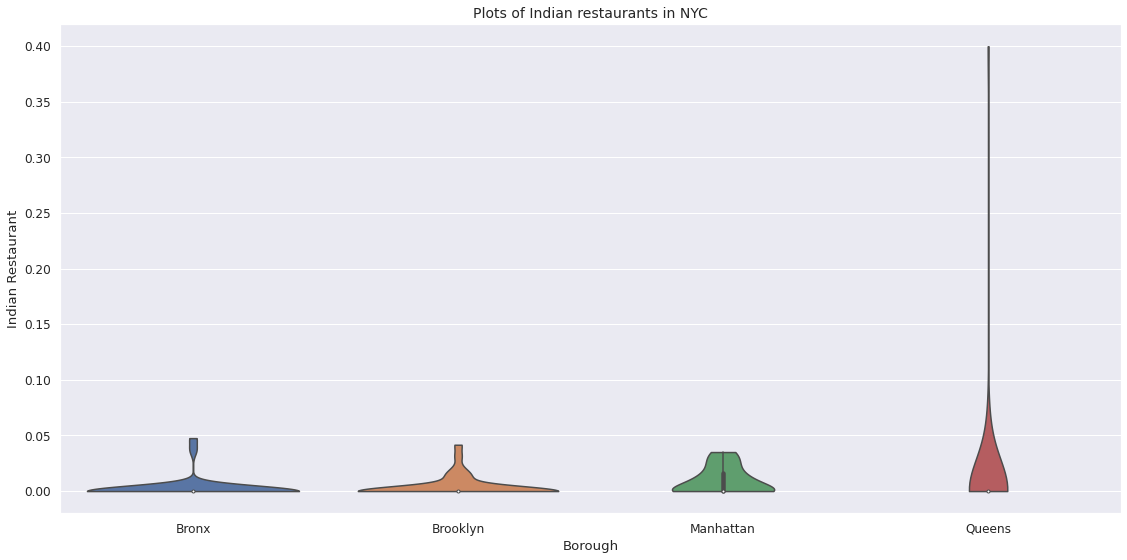

In [22]:
fig = plt.figure(figsize=(19,9))

sb.set(font_scale=1.1)
sb.violinplot(y="Indian Restaurant", x="Borough", data=Merged_NYC, cut=0);

plt.title('Plots of Indian restaurants in NYC', fontsize=14)
plt.show()

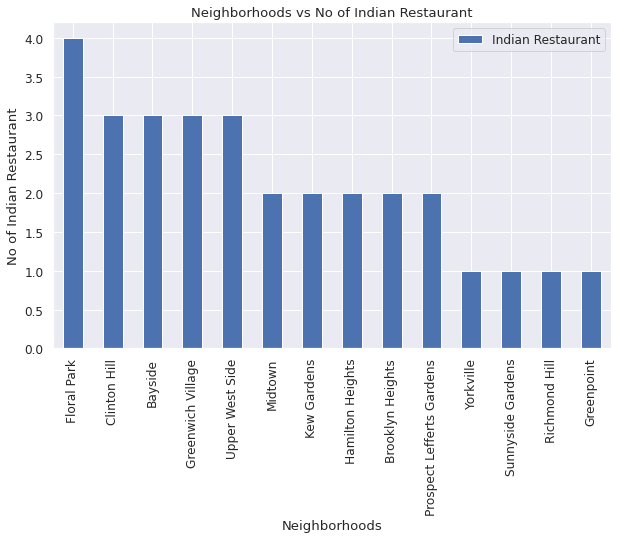

In [23]:
graph = pd.DataFrame(onehot_NYC.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by ='Indian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Indian Restaurant")
plt.title("Neighborhoods vs No of Indian Restaurant")
plt.show()

# Analysis using Clustering

Lets see how many neighborhoods do not have Indian restaurants

In [70]:
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"Venue Category": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(NYC_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)


df_Ind_rest_counts =  Indian_restaurants.groupby(['Neighborhood']).count().rename(columns={"Venue Category": "IndRestaurantCount"})[['IndRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(NYC_venues['Neighborhood']) - set(Indian_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant
if noRestList != []:
    df_Ind_rest_counts = df_Ind_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'IndRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_Ind_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_Ind_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Indian restaurant'.format(len(noRestList)))


115 neighborhoods do not have any Indian restaurant


Now let's create a new dataframe and display  top 10 venues for each neighborhood

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Grouped_NYC['Neighborhood']

for ind in np.arange(Grouped_NYC.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Grouped_NYC.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood      1st Most Common Venue  \
0                      Arverne                  Surf Spot   
1                   Bath Beach                Pizza Place   
2            Battery Park City                       Park   
3                    Bay Ridge                        Spa   
4                  Bay Terrace             Clothing Store   
5                   Baychester                 Donut Shop   
6                      Bayside                        Bar   
7                 Bedford Park                      Diner   
8                      Belmont         Italian Restaurant   
9                  Bensonhurst         Chinese Restaurant   
10                Bergen Beach            Harbor / Marina   
11                  Blissville              Deli / Bodega   
12                Borough Park                       Bank   
13                Breezy Point                      Beach   
14                   Briarwood              Deli / Bodega   
15              Brighton Beach                      Beach   
16            Brooklyn Heights                Yoga Studio   
17                  Brookville              Deli / Bodega   
18                 Brownsville              Moving Target   
19                    Bushwick                        Bar   
20             Cambria Heights       Caribbean Restaurant   
21                    Canarsie           Asian Restaurant   
22             Carroll Gardens         Italian Restaurant   
23                 Castle Hill                     Market   
24                     Chelsea                Coffee Shop   
25                   Chinatown         Chinese Restaurant   
26                Clason Point                       Park   
27                     Clinton                    Theater   
28                Clinton Hill         Italian Restaurant   
29                  Co-op City       Fast Food Restaurant   
30               College Point              Deli / Bodega   
31                Coney Island           Baseball Stadium   
32                      Corona         Chinese Restaurant   
33               Crown Heights                Pizza Place   
34                  Douglaston              Deli / Bodega   
35                       Dumbo                Coffee Shop   
36               Dyker Heights               Burger Joint   
37               East Elmhurst                 Donut Shop   
38               East Flatbush           Department Store   
39                 East Harlem         Mexican Restaurant   
40                East Tremont                Pizza Place   
41                East Village                        Bar   
42                    Elmhurst            Thai Restaurant   
43                     Erasmus       Caribbean Restaurant   
44                Far Rockaway              Deli / Bodega   
45                   Fieldston                      River   
46          Financial District                Coffee Shop   
47                    Flatbush       Caribbean Restaurant   
48                   Flatlands                   Pharmacy   
49                 Floral Park          Indian Restaurant   
50                     Fordham                Pizza Place   
51                Forest Hills                        Gym   
52                 Fort Greene                Flower Shop   
53               Fresh Meadows                Bus Station   
54                  Georgetown                       Bank   
55                   Glen Oaks                   Pharmacy   
56                    Glendale              Deli / Bodega   
57                   Gravesend                     Bakery   
58                  Greenpoint                        Bar   
59           Greenwich Village         Italian Restaurant   
60            Hamilton Heights                Pizza Place   
61                      Hollis             Baseball Field   
62                  Holliswood                 Playground   
63                   Homecrest                       Bank   
64                Howard Beach                 Bagel 

Now lets cluster the nieghborhoods

In [27]:
kclusters = 5
Grouped_NYC_clustering = Grouped_NYC.drop('Neighborhood', 1)

# k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Grouped_NYC_clustering)

kmeans.labels_[0:10] 

array([3, 0, 3, 3, 0, 0, 3, 0, 0, 3], dtype=int32)

In [28]:
Merged_NYC = NYC_df

# adding clustering labels
Merged_NYC['Cluster Labels'] = kmeans.labels_
Merged_NYC = Merged_NYC.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Merged_NYC.head()

Borough Neighborhood   Latitude  Longitude  Population  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201       29158               3   
1   Bronx   Co-op City  40.874294 -73.829939       43752               0   
2   Bronx    Fieldston  40.895437 -73.905643        3292               3   
3   Bronx    Riverdale  40.890834 -73.912585       48049               3   
4   Bronx  Kingsbridge  40.881687 -73.902818       10669               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy                  Food            Laundromat   
1  Fast Food Restaurant        Baseball Field            Restaurant   
2                 River           Bus Station      Business Service   
3                  Park           Bus Station        Baseball Field   
4           Pizza Place                   Bar           Supermarket   

  4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
0          Dessert Shop           Gas Station             Ice Cream Shop   
1            Bagel Shop                  Park                Pizza Place   
2                 Plaza         Women's Store                       Food   
3          Home Service                  Bank                        Gym   
4    Mexican Restaurant        Sandwich Place  Latin American Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Donut Shop        Sandwich Place    Falafel Restaurant   
1           Supermarket              Pharmacy         Grocery Store   
2    Falafel Restaurant        Farmers Market  Fast Food Restaurant   
3                 Plaza            Food Truck            Food Stand   
4                Bakery    Spanish Restaurant            Donut Shop   

  10th Most Common Venue  
0         Farmers Market  
1            Bus Station  
2    Filipino Restaurant  
3         Farmers Market  
4               Pharmacy

In [30]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Merged_NYC['Latitude'], Merged_NYC['Longitude'], Merged_NYC['Neighborhood'], Merged_NYC['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [31]:
Merged_NYC.loc[Merged_NYC['Cluster Labels'] == 0, Merged_NYC.columns[[1] + list(range(5, Merged_NYC.shape[1]))]]

Neighborhood  Cluster Labels      1st Most Common Venue  \
1             Co-op City               0       Fast Food Restaurant   
4            Kingsbridge               0                Pizza Place   
5               Woodlawn               0                Pizza Place   
7         Williamsbridge               0                        Bar   
8             Baychester               0                 Donut Shop   
12        Morris Heights               0              Deli / Bodega   
23          Clason Point               0                       Park   
30             Olinville               0       Caribbean Restaurant   
32             Unionport               0  Latin American Restaurant   
33             Bay Ridge               0                        Spa   
34           Bensonhurst               0         Chinese Restaurant   
40         Crown Heights               0                Pizza Place   
44           Brownsville               0              Moving Target   
47      Brooklyn Heights               0                Yoga Studio   
49           Fort Greene               0                Flower Shop   
50            Park Slope               0                Coffee Shop   
54          Coney Island               0           Baseball Stadium   
55            Bath Beach               0                Pizza Place   
56          Borough Park               0                       Bank   
57         Dyker Heights               0               Burger Joint   
62               Midwood               0                Pizza Place   
63            Georgetown               0                       Bank   
64             Chinatown               0         Chinese Restaurant   
67      Hamilton Heights               0                Pizza Place   
70       Upper East Side               0         Italian Restaurant   
71             Yorkville               0         Italian Restaurant   
72       Upper West Side               0         Italian Restaurant   
74               Midtown               0                Coffee Shop   
77     Greenwich Village               0         Italian Restaurant   
81   Morningside Heights               0                       Park   
82     Battery Park City               0                       Park   
84              Woodside               0              Grocery Store   
85       Jackson Heights               0  Latin American Restaurant   
90           Kew Gardens               0         Chinese Restaurant   
91         Richmond Hill               0  Latin American Restaurant   
94         East Elmhurst               0                 Donut Shop   
95             Ridgewood               0                       Café   
96              Glendale               0              Deli / Bodega   
99      South Ozone Park               0                       Park   
100        College Point               0              Deli / Bodega   
102          Little Neck               0          Korean Restaurant   
106        Fresh Meadows               0                Bus Station   
107            Briarwood               0              Deli / Bodega   
108      Oakland Gardens               0          Korean Restaurant   
109       Queens Village               0                   Bus Stop   
117         Breezy Point               0                      Beach   
120             Neponsit               0                      Beach   
122           Holliswood               0                 Playground   
126         North Corona               0              Deli / Bodega   
127                Rugby               0       Caribbean Restaurant   
130           Mount Hope               0              Grocery Store   
132           Turtle Bay               0         Italian Restaurant   
138            Homecrest               0                       Bank   
139       Middle Village               0                     Bakery   
140              Erasmus               0       Caribbean Restaurant   

           2nd Most Common Venue   

Cluster 2

In [32]:
Merged_NYC.loc[Merged_NYC['Cluster Labels'] == 1, Merged_NYC.columns[[1] + list(range(5, Merged_NYC.shape[1]))]]

Neighborhood  Cluster Labels      1st Most Common Venue  \
11    University Heights               1  Latin American Restaurant   
14          East Tremont               1                Pizza Place   
17            Mott Haven               1                        Gym   
20           Hunts Point               1                Pizza Place   
21            Morrisania               1                Bus Station   
29           Castle Hill               1                     Market   
36            Greenpoint               1                        Bar   
38        Brighton Beach               1                      Beach   
43      Prospect Heights               1                        Bar   
45          Williamsburg               1                Coffee Shop   
48       Carroll Gardens               1         Italian Restaurant   
53           Mill Island               1                  Locksmith   
73               Clinton               1                    Theater   
88                Corona               1         Chinese Restaurant   
89          Forest Hills               1                        Gym   
97             Rego Park               1                     Bakery   
101              Bayside               1                        Bar   
110               Hollis               1             Baseball Field   
111        South Jamaica               1                Bus Station   
112           St. Albans               1       Caribbean Restaurant   
113  Springfield Gardens               1                Bus Station   
114      Cambria Heights               1       Caribbean Restaurant   
116         Far Rockaway               1              Deli / Bodega   
118          Bay Terrace               1             Clothing Store   
134    Sunnyside Gardens               1                        Bar   

         2nd Most Common Venue 3rd Most Common Venue  \
11                 Pizza Place        Sandwich Place   
14               Women's Store           Supermarket   
17          Spanish Restaurant           Pizza Place   
20                   Juice Bar             BBQ Joint   
21              Discount Store  Fast Food Restaurant   
29   Latin American Restaurant                 Diner   
36                 Pizza Place           Coffee Shop   
38          Russian Restaurant            Restaurant   
43          Mexican Restaurant          Cocktail Bar   
45                         Bar            Bagel Shop   
48                 Coffee Shop           Pizza Place   
53                        Pool         Women's Store   
73        Gym / Fitness Center    Italian Restaurant   
88          Mexican Restaurant                Bakery   
89        Gym / Fitness Center           Yoga Studio   
97              Sandwich Place    Chinese Restaurant   
101         Chinese Restaurant           Pizza Place   
110              Shopping Mall                  Park   
111              Deli / Bodega                Bakery   
112               Dance Studio                  Café   
113                 Donut Shop   Fried Chicken Joint   
114                  Nightclub    Chinese Restaurant   
116         Chinese Restaurant           Pizza Place   
118              Women's Store            Donut Shop   
134              Grocery Store           Pizza Place   

           4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
11             Convenience Store   Fried Chicken Joint           Supermarket   
14                Breakfast Spot                  Café     Mobile Phone Shop   
17                    Donut Shop     Mobile Phone Shop   Peruvian Restaurant   
20                 Grocery Store                  Café            Restaurant   
21                  Liquor Store            Donut Shop    Seafood Restaurant   
29                      Pharmacy                  Bank        Cosmetics Shop   
36                  Cocktail Bar     French Restaurant      Sushi Restaurant   
38   Eastern European Restaurant      Sushi Restaurant          Gour

Cluster 3

In [33]:
Merged_NYC.loc[Merged_NYC['Cluster Labels'] == 2, Merged_NYC.columns[[1] + list(range(5, Merged_NYC.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
86     Elmhurst               2       Thai Restaurant    Mexican Restaurant   

   3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
86    Chinese Restaurant       Bubble Tea Shop  Vietnamese Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
86      Sushi Restaurant      Malay Restaurant                  Park   

   9th Most Common Venue 10th Most Common Venue  
86                   Bar                   Bank

Cluster 4

In [34]:
Merged_NYC.loc[Merged_NYC['Cluster Labels'] == 3, Merged_NYC.columns[[1] + list(range(5, Merged_NYC.shape[1]))]]

Neighborhood  Cluster Labels   1st Most Common Venue  \
0                    Wakefield               3                Pharmacy   
2                    Fieldston               3                   River   
3                    Riverdale               3                    Park   
6                      Norwood               3                    Park   
9               Pelham Parkway               3           Deli / Bodega   
10                Bedford Park               3                   Diner   
13                     Fordham               3             Pizza Place   
15                  West Farms               3             Bus Station   
16                     Melrose               3             Pizza Place   
18                 Port Morris               3  Furniture / Home Store   
19                    Longwood               3           Grocery Store   
22                   Soundview               3      Chinese Restaurant   
24                 Throgs Neck               3             Coffee Shop   
25                 Parkchester               3             Supermarket   
26                     Belmont               3      Italian Restaurant   
27              Spuyten Duyvil               3            Intersection   
28                  Pelham Bay               3                    Bank   
31              Pelham Gardens               3             Bus Station   
35                 Sunset Park               3       Mobile Phone Shop   
37                   Gravesend               3                  Bakery   
39                    Flatbush               3    Caribbean Restaurant   
41               East Flatbush               3        Department Store   
42             Windsor Terrace               3                   Diner   
46                    Bushwick               3                     Bar   
51                    Canarsie               3        Asian Restaurant   
52                   Flatlands               3                Pharmacy   
58                 Marine Park               3             Pizza Place   
59                Clinton Hill               3      Italian Restaurant   
60   Prospect Lefferts Gardens               3                  Bakery   
61                Bergen Beach               3         Harbor / Marina   
65          Washington Heights               3                    Café   
66                      Inwood               3                  Lounge   
68              Manhattanville               3             Coffee Shop   
69                 East Harlem               3      Mexican Restaurant   
75                 Murray Hill               3                   Hotel   
76                     Chelsea               3             Coffee Shop   
78                East Village               3                     Bar   
79             Lower East Side               3      Chinese Restaurant   
80                     Tribeca               3                    Park   
83          Financial District               3             Coffee Shop   
87                Howard Beach               3              Bagel Shop   
92            Long Island City               3             Coffee Shop   
98                   Woodhaven               3           Deli / Bodega   
103                 Douglaston               3           Deli / Bodega   
104                  Glen Oaks               3                Pharmacy   
105          Kew Gardens Hills               3                    Bank   
115                   Rosedale               3             Supermarket   
119                    Arverne               3               Surf Spot   
121                Floral Park               3       Indian Restaurant   
123                 Lindenwood               3           Deli / Bodega   
124                  Laurelton               3    Caribbean Restaurant   
125                 Brookville               3           Deli / Bodega   
128                 Mill Basin               3      Chinese Restaurant   
129                   

Cluster 5

In [35]:
Merged_NYC.loc[Merged_NYC['Cluster Labels'] == 4, Merged_NYC.columns[[1] + list(range(5, Merged_NYC.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
93    Sunnyside               4           Pizza Place    Chinese Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
93    Italian Restaurant        Discount Store                Bakery   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
93         Deli / Bodega    Mexican Restaurant           Coffee Shop   

        9th Most Common Venue 10th Most Common Venue  
93  South American Restaurant   Fast Food Restaurant

In [38]:
print(Merged_NYC.groupby(['Cluster Labels','1st Most Common Venue' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

Merged_NYC.groupby(['Cluster Labels','2nd Most Common Venue' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                          Neighborhood Count
Cluster Labels 1st Most Common Venue                        
0              Bakery                                      1
               Bank                                        3
               Bar                                         1
               Baseball Stadium                            1
               Beach                                       2
               Burger Joint                                1
               Bus Station                                 1
               Bus Stop                                    1
               Café                                        1
               Caribbean Restaurant                        3
               Chinese Restaurant                          3
               Coffee Shop                                 2
               Deli / Bodega                               5
               Donut Shop                                  2
               Fast Food

Neighborhood Count
Cluster Labels 2nd Most Common Venue                          
0              American Restaurant                           1
               Bakery                                        2
               Bank                                          1
               Bar                                           1
               Baseball Field                                1
               Beach Bar                                     1
               Burger Joint                                  1
               Bus Station                                   1
               Café                                          1
               Chinese Restaurant                            4
               Coffee Shop                                   3
               Deli / Bodega                                 3
               Donut Shop                                    1
               Eastern European Restaurant                   1
               Food & Drink Shop                             2
               Grocery Store                                 2
               Gym                                           1
               Gym / Fitness Center                          1
               Hotel                                         2
               Ice Cream Shop                                2
               Lake                                          1
               Mattress Store                                1
               Monument / Landmark                           1
               Park                                          1
               Peruvian Restaurant                           1
               Pharmacy                                      2
               Pizza Place                                   4
               Plaza                                         1
               Pool                                          1
               Recreation Center                             1
               Sandwich Place                                2
               Seafood Restaurant                            1
               Soup Place                                    1
               Sushi Restaurant                              1
               Trail                                         1
               Wine Bar                                      1
               Wine Shop                                     1
               Yoga Studio                                   1
1              Bar                                           1
               Chinese Restaurant                            2
               Coffee Shop                                   1
               Dance Studio                                  1
               Deli / Bodega                                 1
               Discount Store                                1
               Donut Shop                                    1
               Grocery Store                                 1
               Gym / Fitness Center                          2
               Juice Bar                                     1
               Latin American Restaurant                     1
               Mexican Restaurant                            2
               Nightclub                                     1
               Pizza Place                                   2
               Pool                                          1
               Russian Restaurant                            1
               Sandwich Place                                1
               Shopping Mall                                 1
               Spanish Restaurant                            1
               Women's Store                                 2
2              Mexican Restaurant                            1
3              American Restaurant                           2
               Art Gallery                                   1
               Bakery                                        1
            

# Discussion and Conclusion

Cluster 4 suffers from restaurant. Especially there is no Indian restaurant. We can think about Cluster 4.

Cluster 0 especially likes Fast Food, burger Joints, this part may not like Indian tastes . We can only think about cluster 4 may be for now.

Cluster 2, 3 are centers full of restaurants as we saw in the map too.

cluster 1 has an amalgam of restaurants. so having an Indian restaurant among those restaurants can be a good decision.